In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#chargement des données
data=pd.read_csv("~/Téléchargements/user_exo_2M.csv",",")

/tmp/ipykernel_5232/1750711206.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data=pd.read_csv("~/Téléchargements/user_exo_2M.csv",",")


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   yob        int64  
 1   domain     object 
 2   firstname  object 
 3   zipcode    float64
 4   gender     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 76.3+ MB


In [5]:
#première vision du dataset on remarque les valeurs manquantes dans les colonnes gender et yob 
data.head(20)

,yob,domain,firstname,zipcode,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961,@sfr.fr,7ff135854376850,78580.0,M
2,1977,@free.fr,172522ec1028ab7,62640.0,NaN
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN
5,1975,@wanadoo.fr,57c2877c1d84c4b,92600.0,M
6,1974,@gmail.com,d47de916cacd0b7,65200.0,M
7,1957,@free.fr,7ff135854376850,83250.0,NaN
8,-1,@live.fr,a5410ee37744c57,5100.0,M
9,-1,@wanadoo.fr,60784186ea5b29f,68300.0,NaN


In [6]:
data.isna().sum()
# plus de 800 000 valeurs manquantes dans gender
# plus de 17 000 valeurs manquantes dans zipcode

yob               0
domain            0
firstname         0
zipcode       17194
gender       804954
dtype: int64

In [7]:
data["yob"].value_counts()
#800 000 valeurs manquantes en date de naissance

-1       800000
 1985     40116
 1990     36679
 1988     35236
 1987     35120
          ...  
 1926       113
 1911        97
 1922        80
 1924        73
 1923        55
Name: yob, Length: 85, dtype: int64

In [8]:
corr_values=data.corr()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   yob        int64  
 1   domain     object 
 2   firstname  object 
 3   zipcode    float64
 4   gender     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 76.3+ MB


In [10]:
print(corr_values["yob"])

yob        1.000000
zipcode   -0.000098
Name: yob, dtype: float64


In [11]:
#imputation supervisée pour déterminer les  800 000 valeurs manquantes dans les colonnes yob et gender

In [12]:
data_known=data[(data["gender"].notna()) & (data["yob"] != -1)]
data_missing=data[(data["gender"].isna()) | (data["yob"] == -1)]

In [13]:
# on vérifie la corrélation de firstname avec gender

from scipy.stats import chi2_contingency

contingency = pd.crosstab(data_known["firstname"], data_known["gender"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value : {p}")
#p<0.05 donc pas d'indépendance entre les deux colonnes

p-value : 0.0


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

cramers_v(data_known["firstname"], data_known["gender"])
# de même 0.89 montre une forte corrélation entre firstname et gender d'où l'hypothèse de forte dépendance entre ces variables




0.8917362877408304

In [15]:
cramers_v(data_known["domain"], data_known["gender"])
#faible corrélation indépendance probable, le domaine n'est pas une bonne feature pour gender

0.09482447800521282

In [16]:
from scipy.stats import f_oneway

grouped = [group["zipcode"].dropna().values for name, group in data_known.groupby("gender")]
f_stat, p_val = f_oneway(*grouped)
print(f"p-value : {p_val}")
#valeur inférieure à 0.05 donc une corrélation significative

p-value : 8.409228003455207e-09


In [17]:
#on va encoder via du target encoding firstname et retirer domain pour entrainer notre modèle et effectuer des 
#prédictions sur gender

In [18]:
data_known.isna().sum()

yob             0
domain          0
firstname       0
zipcode      5956
gender          0
dtype: int64

In [19]:
data_known=data_known.dropna()

In [20]:
#on vérifie qu'il n'y a plus de valeurs NaN 
data_known.isna().sum()

yob          0
domain       0
firstname    0
zipcode      0
gender       0
dtype: int64

In [21]:
data_known_gender=data_known.copy()
data_known_yob=data_known.copy()

In [22]:
#modèle pour la variable gender

In [23]:

data_known_gender=data_known_gender.drop(columns="domain",axis=1)

In [24]:
data_known_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790763 entries, 0 to 1999996
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   yob        790763 non-null  int64  
 1   firstname  790763 non-null  object 
 2   zipcode    790763 non-null  float64
 3   gender     790763 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 30.2+ MB


In [25]:
#target encoder
# Étape 1 : Convertir 'gender' en valeurs numériques (M=1, F=0)
data_known_gender['gender_encoded'] = data_known['gender'].map({'M': 1, 'F': 0})


target_encoding = data_known_gender.groupby('firstname')['gender_encoded'].mean()

# Remplacer 'firstname' par la moyenne de la cible
data_known_gender['firstname_encoded'] = data_known_gender['firstname'].map(target_encoding)

In [26]:
data_known_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790763 entries, 0 to 1999996
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   yob                790763 non-null  int64  
 1   firstname          790763 non-null  object 
 2   zipcode            790763 non-null  float64
 3   gender             790763 non-null  object 
 4   gender_encoded     790763 non-null  int64  
 5   firstname_encoded  790763 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 42.2+ MB


In [27]:
data_known_gender_labels=data_known_gender["gender_encoded"]

In [28]:
data_known_gender=data_known_gender.drop(columns=["gender","gender_encoded","firstname"],axis=1)

In [29]:
X=data_known_gender
y=data_known_gender_labels

In [30]:
from sklearn.model_selection import train_test_split
# répartitions de notre dataset en entrainement et test
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y, test_size=0.2, random_state=42)



In [31]:
from sklearn.ensemble import RandomForestClassifier

# Initialiser le modèle forêt aléatoire
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner
model.fit(X_train_gender, y_train_gender)



RandomForestClassifier(random_state=42)

In [32]:
# prédiction et mesure de précision du modèle
y_pred_gender = model.predict(X_test_gender)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_gender, y_pred_gender)
print(f"Accuracy : {accuracy:.2f}")
#modèle de prédiction de gender est performant sur les données d'entrainement

Accuracy : 0.94


In [33]:
X_missing = data_missing.copy()

In [34]:
data_missing.shape

(1203281, 5)

In [35]:
X_missing

,yob,domain,firstname,zipcode,gender
2,1977,@free.fr,172522ec1028ab7,62640.0,NaN
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN
7,1957,@free.fr,7ff135854376850,83250.0,NaN
8,-1,@live.fr,a5410ee37744c57,5100.0,M
...,...,...,...,...,...
1999993,-1,@gmail.com,2e92d0ae281932f,80090.0,F
1999994,-1,@orange.fr,56910c52ed70539,38100.0,NaN
1999997,1998,@gmail.com,029f0f59eba0903,21000.0,NaN
1999998,-1,@hotmail.com,deb97a759ee7b8b,26240.0,M


In [36]:
X_missing_gender=X_missing[X_missing["gender"].isna()]

In [37]:
#notre df data_known_gender mais sans certaines transformations faites précedemment
data_known_gender_2 = data_known.copy()

In [38]:
#target encoder
# Convertir 'gender' en valeurs numériques (M=1, F=0)
data_known_gender_2['gender_encoded'] = data_known['gender'].map({'M': 1, 'F': 0})


target_encoding = data_known_gender_2.groupby('firstname')['gender_encoded'].mean()

# Remplacer 'firstname' par la moyenne de la cible
data_known_gender_2['firstname_encoded'] = data_known_gender_2['firstname'].map(target_encoding)

#target encoder en réutilisant le mapping réalisé sur les données d'entrainement

#reprendre le mapping dans la variable encoding_map
encoding_map = data_known_gender_2.groupby('firstname')['gender_encoded'].mean().to_dict()
global_mean = np.mean(list(encoding_map.values()))

#appliquer le target encoding sur X_missing
X_missing_gender['firstname_encoded'] = X_missing['firstname'].map(encoding_map)

#remplir les prénoms inconnus avec la moyenne globale
X_missing_gender['firstname_encoded'].fillna(global_mean, inplace=True)


/tmp/ipykernel_5232/4075943152.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_gender['firstname_encoded'] = X_missing['firstname'].map(encoding_map)
/tmp/ipykernel_5232/4075943152.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_gender['firstname_encoded'].fillna(global_mean, inplace=True)


In [39]:
X_missing_gender=X_missing_gender.drop(columns=["domain","firstname","gender"],axis=1)

In [40]:
X_missing_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804954 entries, 2 to 1999999
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   yob                804954 non-null  int64  
 1   zipcode            796691 non-null  float64
 2   firstname_encoded  804954 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 24.6 MB


In [41]:
# Prédire les valeurs de gender manquantes
gender_pred = model.predict(X_missing_gender)



In [42]:
#prédiction sur les valeurs manquantes de gender 
gender_pred

array([1, 1, 1, ..., 1, 0, 0])

In [43]:
# il reste justa à ajouter les prédictions dans ton DataFrame original
data_full= data.copy()

In [44]:
data_full["gender"].isna().sum()

804954

In [45]:
# Masque pour repérer les lignes avec gender manquant
mask_missing_gender = data_full["gender"].isna()



In [46]:
#verification que la taille des predictions correspond au nombre de valeurs manquantes dans le dataset initial
assert mask_missing_gender.sum() == len(gender_pred), "Mismatch entre NaNs et prédictions"


In [47]:
# Remplacement direct
data_full.loc[mask_missing_gender, "gender"] = gender_pred


In [48]:
data_full["gender"].isna().sum()

0

In [49]:
data_full["gender"] = data_full["gender"].apply(
    lambda x: 1 if x == 'M' else 0 if x == 'F' else x
)


In [50]:
#on a bien réussi à prédire l'ensemble des NaN maintenant on va évaluer la qualité globale des prédictions faite grace à une validation
data_full["gender"].value_counts()

1    1021032
0     978968
Name: gender, dtype: int64

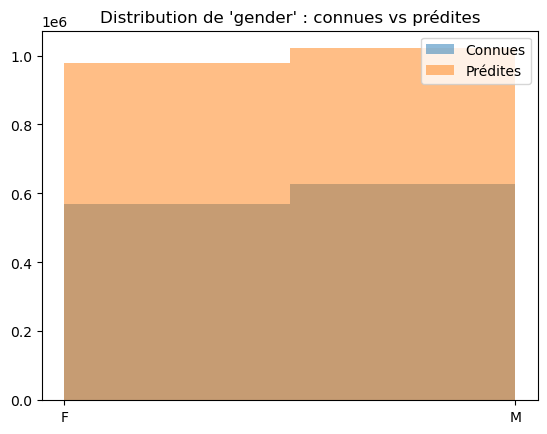

In [51]:
import matplotlib.pyplot as plt

# Comparaison de la répartition
original = data[data["gender"].notna()]["gender"]
predicted = data_full["gender"] 

plt.hist(original, bins=2, alpha=0.5, label="Connues")
plt.hist(predicted, bins=2, alpha=0.5, label="Prédites")
plt.legend()
plt.title("Distribution de 'gender' : connues vs prédites")
plt.show()


In [52]:
original=original.apply(lambda x: 1 if x=='M' else 0 if x=='F' else x)

In [53]:
n=len(original)
m=len(predicted)

In [54]:
accuracy_validation = accuracy_score(original, predicted.sample(n))
print(f"Accuracy : {accuracy_validation:.2f}")

#notre imputer est aussi bon que le hasard pour prédire le sexe

Accuracy : 0.50


In [55]:
#on va réaliser la même opération pour entrainer puis prédire les valeurs manquantes de yob

In [98]:
data_known_yob=data_known.copy()

In [99]:
data_known_yob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790763 entries, 0 to 1999996
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   yob        790763 non-null  int64  
 1   domain     790763 non-null  object 
 2   firstname  790763 non-null  object 
 3   zipcode    790763 non-null  float64
 4   gender     790763 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 36.2+ MB


In [100]:
corr_values_2=data_known_yob.corr()

In [101]:
# on vérifie la corrélation de firstname avec gender

from scipy.stats import chi2_contingency

contingency = pd.crosstab(data_known["firstname"], data_known["yob"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value : {p}")
#p<0.05 donc pas d'indépendance entre les deux colonnes

p-value : 0.0


In [102]:
# on vérifie la corrélation de domain avec yob

from scipy.stats import chi2_contingency

contingency = pd.crosstab(data_known["domain"], data_known["yob"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value : {p}")
#p<0.05 donc pas d'indépendance entre les deux colonnes
#contrairement à avec gender le nom de domain n'est pas indépendant de l'année de naissance

p-value : 0.0


In [103]:
#on va encoder les variables avant de passer à l'entrainement du modèle

In [104]:
data_known_yob["gender"]=data_known_yob["gender"].map({"M": 1, "F": 0})

In [105]:
target_encoding2=data_known_yob.groupby("firstname")["yob"].mean()
data_known_yob["firstname_encoded"]=data_known_yob["firstname"].map(target_encoding2)

In [106]:
target_encoding3=data_known_yob.groupby("domain")["yob"].mean()
data_known_yob["domain_encoded"]=data_known_yob["domain"].map(target_encoding3)

In [107]:
data_known_yob=data_known_yob.drop(columns=["firstname","domain","gender"],axis=1)

In [108]:
y2=data_known_yob["yob"]
X2=data_known_yob.drop(columns="yob",axis=1)

In [109]:
from sklearn.model_selection import train_test_split

X_train_yob, X_test_yob, y_train_yob, y_test_yob=train_test_split(X2, y2, test_size=0.2, random_state=42)

In [113]:
X_train_yob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632610 entries, 967405 to 307406
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   zipcode            632610 non-null  float64
 1   firstname_encoded  632610 non-null  float64
 2   domain_encoded     632610 non-null  float64
dtypes: float64(3)
memory usage: 19.3 MB


In [110]:
import lightgbm as lgb

model2 = lgb.LGBMClassifier(class_weight='balanced')  # Ajoute ça si classes déséquilibrées
model2.fit(X_train_yob, y_train_yob)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 632610, number of used features: 3
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM] [Info] Start training from score -4.430817
[LightGBM]

LGBMClassifier(class_weight='balanced')

In [111]:
y_pred_yob=model2.predict(X_test_yob)

from sklearn.metrics import accuracy_score

accuracy2=accuracy_score(y_test_yob,y_pred_yob)
print("Accuracy:", accuracy2)

Accuracy: 0.03784942429166693


In [84]:
#prediction des valeurs NaN 

X_missing_yob=data_missing.copy()

In [85]:
X_missing_yob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203281 entries, 2 to 1999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   yob        1203281 non-null  int64  
 1   domain     1203281 non-null  object 
 2   firstname  1203281 non-null  object 
 3   zipcode    1192043 non-null  float64
 4   gender     398327 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 87.3+ MB


In [88]:
X_missing_yob=X_missing_yob[X_missing_yob["yob"] == -1]

In [89]:
X_missing_yob

,yob,domain,firstname,zipcode,gender
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN
8,-1,@live.fr,a5410ee37744c57,5100.0,M
9,-1,@wanadoo.fr,60784186ea5b29f,68300.0,NaN
13,-1,@free.fr,d780182f77b1214,24100.0,M
...,...,...,...,...,...
1999989,-1,@sfr.fr,e409f05a10574ad,85200.0,NaN
1999993,-1,@gmail.com,2e92d0ae281932f,80090.0,F
1999994,-1,@orange.fr,56910c52ed70539,38100.0,NaN
1999998,-1,@hotmail.com,deb97a759ee7b8b,26240.0,M


In [90]:
data_known_yob_2=data_known.copy()

In [93]:
#target encoder
# Étape 1 : Convertir 'gender' en valeurs numériques (M=1, F=0)
data_known_yob_2['gender_encoded'] = data_known['gender'].map({'M': 1, 'F': 0})


target_encoding_ = data_known_yob_2.groupby('firstname')['yob'].mean()

# Remplacer 'firstname' par la moyenne de la cible
data_known_yob_2['firstname_encoded'] = data_known_yob_2['firstname'].map(target_encoding_)

#target encoder en réutilisant le mapping réalisé sur les données d'entrainement

#reprendre le mapping dans la variable encoding_map
encoding_map_ = data_known_yob_2.groupby('firstname')['yob'].mean().to_dict()
global_mean_ = np.mean(list(encoding_map_.values()))

#appliquer le target encoding sur X_missing
X_missing_yob['firstname_encoded'] = X_missing['firstname'].map(encoding_map_)

#remplir les prénoms inconnus avec la moyenne globale
X_missing_yob['firstname_encoded'].fillna(global_mean_, inplace=True)


/tmp/ipykernel_5232/2448104841.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_yob['firstname_encoded'] = X_missing['firstname'].map(encoding_map_)
/tmp/ipykernel_5232/2448104841.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_yob['firstname_encoded'].fillna(global_mean_, inplace=True)


In [94]:
#target encoder
# Étape 1 : Convertir 'gender' en valeurs numériques (M=1, F=0)


target_encoding__ = data_known_yob_2.groupby('domain')['yob'].mean()

# Remplacer 'firstname' par la moyenne de la cible
data_known_yob_2['domain_encoded'] = data_known_yob_2['domain'].map(target_encoding__)

#target encoder en réutilisant le mapping réalisé sur les données d'entrainement

#reprendre le mapping dans la variable encoding_map
encoding_map__ = data_known_yob_2.groupby('domain')['yob'].mean().to_dict()
global_mean__ = np.mean(list(encoding_map__.values()))

#appliquer le target encoding sur X_missing
X_missing_yob['domain_encoded'] = X_missing['domain'].map(encoding_map__)

#remplir les prénoms inconnus avec la moyenne globale
X_missing_yob['domain_encoded'].fillna(global_mean__, inplace=True)


/tmp/ipykernel_5232/3971803994.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_yob['domain_encoded'] = X_missing['domain'].map(encoding_map__)
/tmp/ipykernel_5232/3971803994.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing_yob['domain_encoded'].fillna(global_mean__, inplace=True)


In [95]:
X_missing_yob

,yob,domain,firstname,zipcode,gender,firstname_encoded,domain_encoded
3,-1,@hotmail.com,d3ca5dde60f88db,94100.0,M,1973.470550,1979.678425
4,-1,@gmail.com,bdaae16837dd576,78100.0,NaN,1984.826018,1979.664939
8,-1,@live.fr,a5410ee37744c57,5100.0,M,1973.815107,1980.453293
9,-1,@wanadoo.fr,60784186ea5b29f,68300.0,NaN,1973.670244,1963.423745
13,-1,@free.fr,d780182f77b1214,24100.0,M,1957.703610,1967.800521
...,...,...,...,...,...,...,...
1999989,-1,@sfr.fr,e409f05a10574ad,85200.0,NaN,1988.606643,1968.597402
1999993,-1,@gmail.com,2e92d0ae281932f,80090.0,F,1979.349057,1979.664939
1999994,-1,@orange.fr,56910c52ed70539,38100.0,NaN,1988.406771,1966.842671
1999998,-1,@hotmail.com,deb97a759ee7b8b,26240.0,M,1982.110168,1979.678425


In [96]:
X_missing_yob=X_missing_yob.drop(columns=["firstname","domain","gender","yob"],axis=1)

In [116]:
yob_pred=model2.predict(X_missing_yob)

In [121]:
yob_pred

array([1980, 1995, 1945, ..., 1993, 1984, 1948])

In [129]:
mask_missing_yob=(data_full["yob"] == -1)

In [130]:
#verification que la taille des predictions correspond au nombre de valeurs manquantes dans le dataset initial
assert mask_missing_yob.sum() == len(yob_pred), "Mismatch entre NaNs et prédictions"


In [133]:
data_full.loc[mask_missing_yob, "yob"]=yob_pred

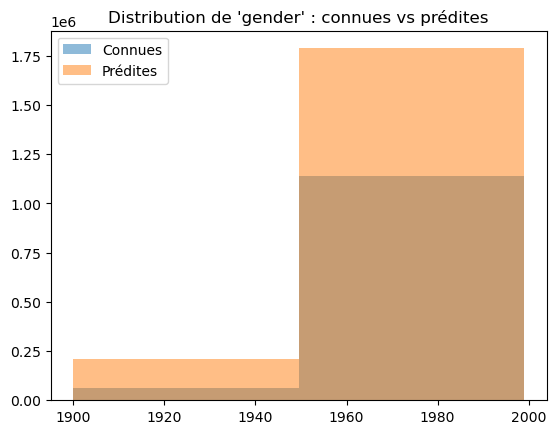

In [139]:
# Comparaison de la répartition
original_yob = data[data["yob"] != -1]["yob"]
predicted_yob = data_full["yob"] 

plt.hist(original_yob, bins=2, alpha=0.5, label="Connues")
plt.hist(predicted_yob, bins=2, alpha=0.5, label="Prédites")
plt.legend()
plt.title("Distribution de 'gender' : connues vs prédites")
plt.show()


In [142]:
n2=len(original_yob)
m2=len(predicted)
print("n2 =",n2)
print("m2 =",m2)

n2 = 1200000
m2 = 2000000


In [143]:
accuracy_yob=accuracy_score(original_yob,predicted_yob.sample(n2))
print("Accuracy :", accuracy_yob)

Accuracy : 0.019255833333333333


In [144]:
data_full["yob"].nunique()

84

In [145]:
1/84

#notre imputer est meilleur que le hasard pour prédire l'année de naissance  0.019 > 0.012

0.011904761904761904